### Аренда велосипедов
Предоставлены данные компании, которая занимается арендой велосипедов в Лондоне. Данные охватывают промежуток в два года: с 4 января 2015 по 3 января 2017. 

Необходимо изучить динамику числа аренд, наличие связи с погодными условиями и выходными, а также объяснить несколько аномалий на графике.

###### Описание данных
- **timestamp** – дата и время (точность до часа)
- **cnt** – количество аренд велосипедов за этот час
- **t1** – температура, в С
- **t2** – температура "ощущается как", в С 
- **hum** – влажность (%)
- **wind_speed** – скорость ветра, км/ч
- **weather_code** – погодные условия:
    - 1 – ясно (SKC)
    - 2 – преимущественно ясно / встречаются отдельные облака (SCT)
    - 3 – облачно / значительные облака (BKN)
    - 4 – пасмурно (OVC)
    - 7 – небольшой дождь Rain/ light Rain shower/ Light rain 
    - 10 – дождь с грозой
    - 26 – снегопад 
    - 94 – ледяной туман (да, такое бывает!)
- **isholiday** – является ли день праздником (1 – праздник, 0 – нет)
- **isweekend** –  является ли день выходным (1 – выходной, 0 – нет)
- **season** – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

In [74]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import scipy.stats as st
import statsmodels.stats.api as sms

In [75]:
# задаём настройки графиков
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(15,7)}
        )

Загрузим данные, проверим число наблюдений и столбцов, наличие пропусков. Приведём переменные к нужным типам.

In [76]:
# грузим данные
london = pd.read_csv('C:/Users/Lenovo/Desktop/Портфолио/Datas/london.csv', parse_dates = ['timestamp'])

In [77]:
london.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [78]:
london.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

Колонки `weather_code`, `is_holiday`, `is_weekend`, `season` нужно перевести в Int.

In [79]:
cols_toint = ['weather_code', 'is_holiday', 'is_weekend', 'season']
london[cols_toint] = london[cols_toint].astype(int)

In [80]:
#проверяем преобразование
london.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code             int32
is_holiday               int32
is_weekend               int32
season                   int32
dtype: object

In [81]:
#проверим, есть ли пропущенные значения
london.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

Пропущенных значений нет, идём строить графики! Для начала попробуем посмотреть на число поездок по датам и времени.

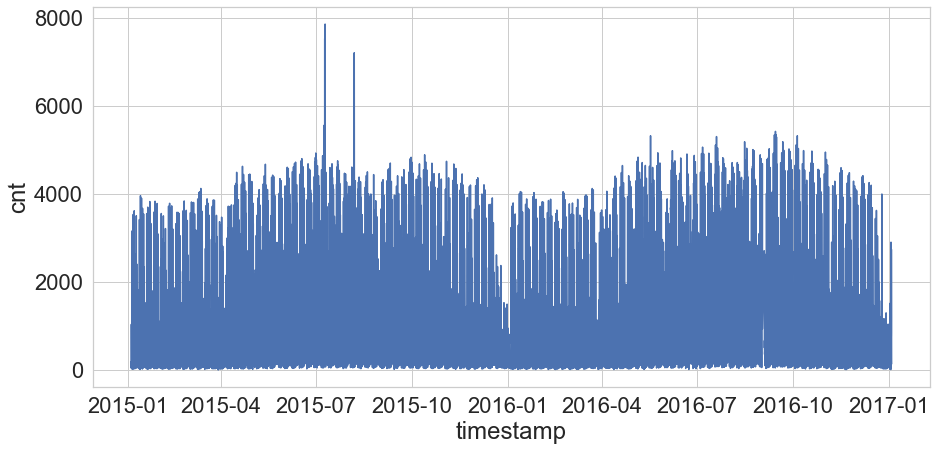

In [82]:
ax = sns.lineplot(x = 'timestamp', y = 'cnt', data = london)

По таким данным очень сложно что-то понять. Чтобы увидеть тренды, их нужно преобразовать.

Используем метод `resample` и аггрегируем число поездок по дням.

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

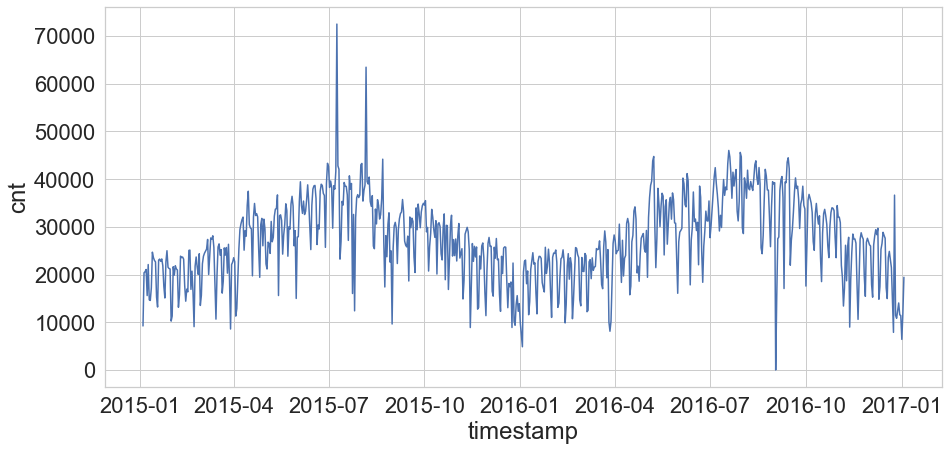

In [83]:
rent_becycle = london.set_index('timestamp') #перед этим нужно перевести даты в индексы
cnt_for_day = rent_becycle.resample(rule='D').agg({'cnt':'sum'})
sns.lineplot(x = 'timestamp', y = 'cnt', data = cnt_for_day)

**Некоторые выводы по графику:**
- Встречаются как очень резкие скачки числа аренд, так и падения.
- Максимальное число аренд за день составляет более 70 000. Минимальное - 0. Неужели в какой-то день не было ни одной аренды велосипеда?
- Зимой число аренд меньше, чем летом, что, в целом, логично. У аренды велосипедов действительно есть сезонность для данной широты.

In [84]:
#Попробуем немного сгладить данные, применив скользящее среднее.
cnt_for_day['rolling_mean'] = round(cnt_for_day.cnt.rolling(3).mean(), 2)
cnt_for_day = cnt_for_day.reset_index()
cnt_for_day.head()

,timestamp,cnt,rolling_mean
0,2015-01-04,9234,NaN
1,2015-01-05,20372,NaN
2,2015-01-06,20613,16739.67
3,2015-01-07,21064,20683.00
4,2015-01-08,15601,19092.67


In [85]:
# Посчитаем разницу между значениями (наблюдаемым и полученным скользящим средним).
cnt_for_day['diff'] = cnt_for_day['cnt'] - cnt_for_day['rolling_mean']

# Вычислим стандартное отклонение
std = np.std(cnt_for_day['diff'])
std

4558.586633328807

In [86]:
# Определим границы 99% доверительного интервала для каждого из наблюдений
cnt_for_day['upper_bound'] = round(cnt_for_day['rolling_mean'] + 2.576 * std, 2)
cnt_for_day['lower_bound'] = round(cnt_for_day['rolling_mean'] - 2.576 * std, 2)

In [87]:
cnt_for_day.head()

,timestamp,cnt,rolling_mean,diff,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN,NaN,NaN
1,2015-01-05,20372,NaN,NaN,NaN,NaN
2,2015-01-06,20613,16739.67,3873.33,28482.59,4996.75
3,2015-01-07,21064,20683.00,381.00,32425.92,8940.08
4,2015-01-08,15601,19092.67,-3491.67,30835.59,7349.75


Изучим аномальные значения из графиков. Выведем те наблюдения, которые выходят из границ 99%-ного доверительного интервала в большую сторону.

In [88]:
cnt_for_day.query('cnt > upper_bound')

,timestamp,cnt,rolling_mean,diff,upper_bound,lower_bound
186,2015-07-09,72504,50705.00,21799.00,62447.92,38962.08
214,2015-08-06,63468,46627.33,16840.67,58370.25,34884.41
609,2016-09-04,27512,14259.00,13253.00,26001.92,2516.08
721,2016-12-25,36653,19650.67,17002.33,31393.59,7907.75


Здесь оказалось 4 наблюдения. Изучим каждое по отдельности в оригинальном датафрейме и попробуем найти причины таких скачков.

In [89]:
london.query("timestamp == '2015-07-09'")

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
4453,2015-07-09,400,16.0,16.0,55.0,14.0,1,0,0,1


Хорошая погода, рабочий день, лето. Как раз сезон аренды. Но при этом аномально высокое значение. В чём причина? Загуглим дату:
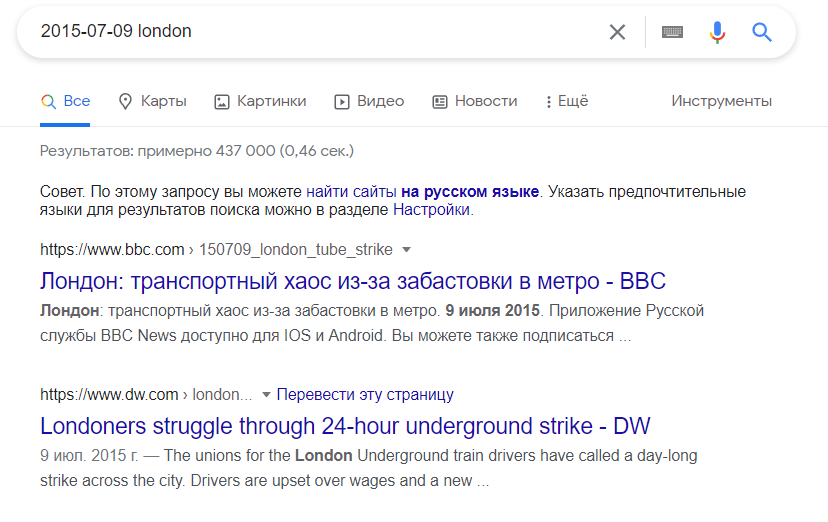
**Все ясно!** В этот день в работники лондонсокого метрополитена объявили забастовку. Приостановка работы метро привела к транспортному коллапсу, чтобы добраться до работы люди арендовали наши велосипеды.

Проделаем аналогичную операцию для остальных дней.

In [90]:
london.query("timestamp == '2015-08-06'")

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
5121,2015-08-06,430,17.5,17.5,75.0,7.5,1,0,0,1


По данным нет ничего особенного. Загуглив дату, видим, что в Лондоне опять забастовки:
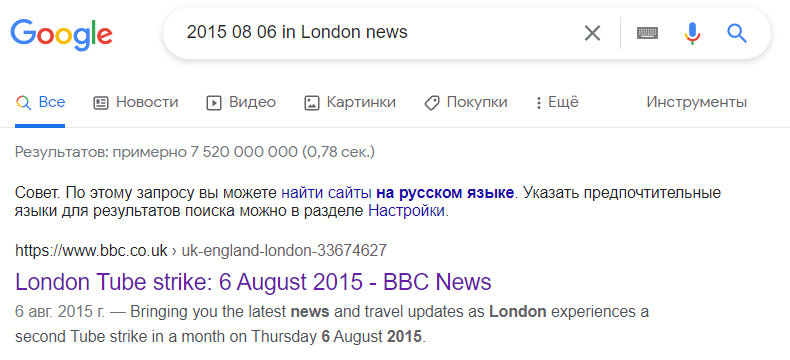

In [91]:
london.query("timestamp == '2016-09-04'")

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
14488,2016-09-04,416,19.0,19.0,88.0,19.0,2,0,1,2


In [92]:
london.query("timestamp == '2016-12-25'")

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
17174,2016-12-25,207,11.0,11.0,77.0,35.0,3,0,1,3


В этих двух вариантах мы можем списать аномалии в данных на выходной. В этом случае люди пользуются велосипедами не как средством передвижения, а как увлечением.

Теперь выведем, которые выходят из границ 99%-ного доверительного интервала в меньшую сторону.

In [96]:
cnt_for_day.query('cnt < lower_bound')

,timestamp,cnt,rolling_mean,diff,upper_bound,lower_bound
130,2015-05-14,15609,28709.33,-13100.33,40452.25,16966.41
189,2015-07-12,23240,36036.67,-12796.67,47779.59,24293.75
201,2015-07-24,16034,31013.67,-14979.67,42756.59,19270.75
232,2015-08-24,17400,29529.33,-12129.33,41272.25,17786.41
314,2015-11-14,8898,21037.33,-12139.33,32780.25,9294.41
607,2016-09-02,0,26086.33,-26086.33,37829.25,14343.41
615,2016-09-10,17080,31262.00,-14182.00,43004.92,19519.08
621,2016-09-16,21967,36193.33,-14226.33,47936.25,24450.41
678,2016-11-12,8990,20878.00,-11888.00,32620.92,9135.08


А вот и нулевое значение за 2016-09-02. В этом случае данные день либо просто не записались, что маловероятно. Скорее всего это ошибка при сборе данных.